In [1]:
# IPython objects
from IPython.display import display, Markdown

# Data analysis libraries
import numpy as np
np.random.seed(2020)
import pandas as pd
from scipy.stats import norm

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
hist_kwargs = {"edgecolor":"black"}

# others
from glob import glob
from tqdm.autonotebook import tqdm

# analysis functions
from Functions import *


/home/agostini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Calibrazione

In [2]:
data_path = "../data/"
calibration_files = glob(data_path+"calibration/*")

In [3]:
def Open_File_Calibration(data_file):
    with open(data_file) as f:
        tot_ev = len(list(f))

    # loop over events and perform analysis
    Ev_list = []
    selected_ev = 0
    with open(data_file) as f:
        with tqdm(total=tot_ev) as pbar:
            for line in f:
                # read event
                ev, evNum, hits = Read_Data(line)
                # select event
                sel, chambers, n_layers = Select_Events_Calibration(ev, hits)
                
                if sel: selected_ev += 1

                # save most important information, in order to plot or reperform the analysis
                # without reading the whole file again
                Ev_list.append(
                    {
                        "Number"    : evNum,
                        "Dataframe" : ev,
                        "Hits"      : hits,
                        "Accepted"  : sel,
                        "Chambers"  : chambers,
                        "Layers"    : n_layers
                    }
                )

                pbar.update()
                
    print("{:35} = {:d}"    .format("Total number of events in the Run", tot_ev))
    print("{:35} = {:d}"    .format("Number of accepted events"        , selected_ev))
    print("{:35} = {:.4f} %".format("Fraction of accepted events"      , selected_ev/tot_ev*100))
    return Ev_list

In [4]:
def Calibration(Ev_list):
    tot_ev = len(Ev_list)
    selected_ev = 0
    # residuals from good events fit
    Ev_residuals = []
    # x position of the best combinations of points per chamber
    X_position = {"up" : [], "down" : []}
    # local fit differences between chambers
    lf_diff = {"slope" : [], "intercept" : []}
    
    print("Performing fit and analysis")
    with tqdm(total=tot_ev) as pbar:
        for event in Ev_list:
            if event["Accepted"]:
                selected_ev += 1
                ev = event["Dataframe"]
                chambers = event["Chambers"]
                n_layers = event["Layers"]
        
                #Local linear fit
                lf_results = Local_Fit(ev, chambers, n_layers, exclusion_layer=True)
                #Global linear fit
                gf_results = Global_Fit(ev, chambers, lf_results)
                Ev_residuals.append(gf_results["residuals"])

                # x coordinates for the points in the optimal combination after local fit per chamber
                X_position["up"]   += [x[1] for x in lf_results[0]["optimal_comb"]]
                X_position["down"] += [x[1] for x in lf_results[1]["optimal_comb"]]
                # local fit differences
                lf_diff["slope"]    .append(lf_results[0]["slope"]    -lf_results[1]["slope"])
                lf_diff["intercept"].append(lf_results[0]["intercept"]-lf_results[1]["intercept"])
            
            pbar.update()
            
    display(Markdown("#### Hit position (cell local coordinates)"))
    
    fig, (ax_up, ax_down) = plt.subplots(figsize=(15,5), ncols=2)

    ax_up.set_title("Up")
    ax_up.hist(X_position["up"]    , bins=30, **hist_kwargs)
    ax_up.set_xlabel("x [mm]")

    ax_down.set_title("Down")
    ax_down.hist(X_position["down"], bins=30, **hist_kwargs)
    ax_down.set_xlabel("x [mm]")

    plt.show()
    
    display(Markdown("#### Difference in slope and intercept between chambers (local fits)"))
    
    fig, (ax_s, ax_i) = plt.subplots(figsize=(15,5), ncols=2)

    ax_s.set_title("Slope")
    ax_s.hist(lf_diff["slope"], bins=30, range=(-0.5,0.5), **hist_kwargs)
    ax_s.set_xlabel()

    ax_i.set_title("Intercept")
    ax_i.hist(lf_diff["intercept"], bins=30, range=(-200,200), **hist_kwargs)

    plt.show()
    
    display(Markdown("#### Residuals in the excluded layer"))
    
    Hit_6_layers = 0
    Hit_7_layers = 0
    Hit_8_layers = 0
    Tot_res      = []
    
    for res in Ev_residuals:
        if len(res) == 0:
            Hit_6_layers += 1
        elif len(res) == 1:
            Hit_7_layers += 1
        elif len(res) == 2:
            Hit_8_layers += 1
        else: continue
        Tot_res += res.tolist()

    #print("percentuale  con 2 esclusi: ",Hit_0/len(residuals)*100," %")
    #print("percentuale  con 1 esclusi: ",Hit_1/len(residuals)*100," %")
    #print("percentuale  con 0 esclusi: ",Hit_2/len(residuals)*100," %")


    fig, (ax_hist, ax_pie) = plt.subplots(figsize=(15,5), ncols=2)
    ax_hist.set_title("Residuals of the points in the excluded layers")
    ax_hist.hist(Tot_res, bins= 30, range=(-20,20), **hist_kwargs)
    
    labels = ['Hit in 8 layers', 'Hit in 7 layers', 'Hit in 6 layers']
    sizes  = [Hit_8_layers/len(Ev_residuals)*100, Hit_7_layers/len(Ev_residuals)*100, Hit_6_layers/len(Ev_residuals)*100]
    patches, _, _ = ax_pie.pie(sizes, labels=labels, explode = [.05,.05,.05], autopct='%1.1f%%', shadow=True, wedgeprops={"edgecolor":'black'})
    ax_pie.legend(patches, labels, loc='upper right', fontsize=14)
    ax_pie.axis('equal')
    ax_pie.set_title("Percentage of excluded layers in the fit")
    
    plt.show()
            
    return Ev_residuals, X_position, lf_diff

### Run 260

#### Reading data

In [5]:
Ev_list = Open_File_Calibration(calibration_files[0])


Total number of events in the Run   = 8182
Number of accepted events           = 2237
Fraction of accepted events         = 27.3405 %


Performing fit and analysis


#### Hit position (cell local coordinates)

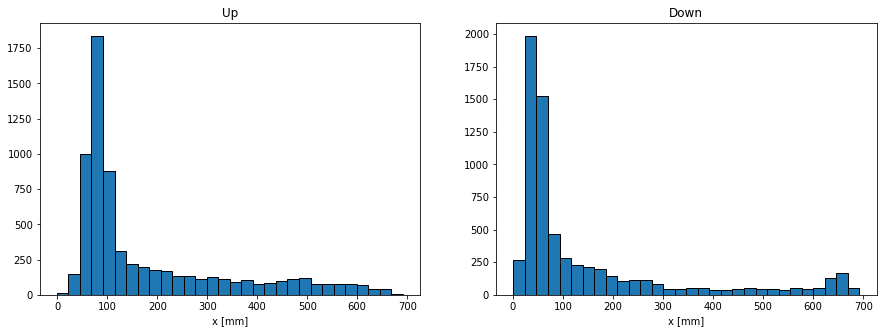

#### Difference in slope and intercept between chambers (local fits)

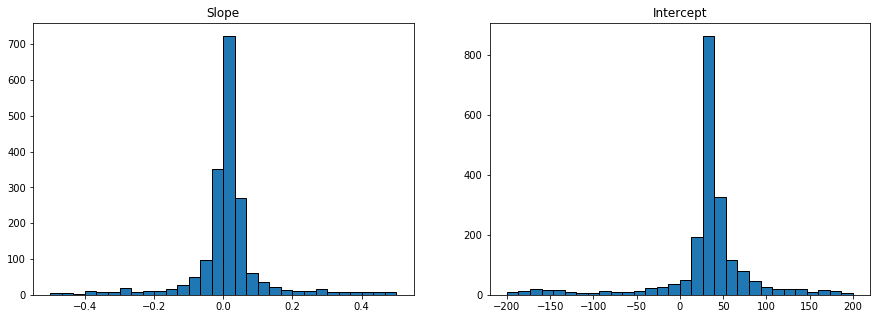

#### Residuals in the excluded layer

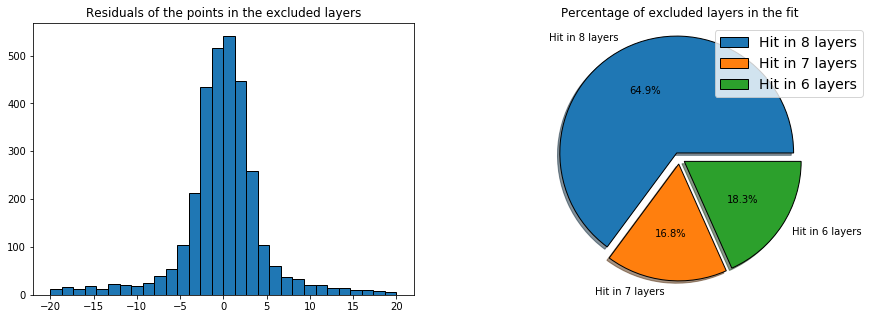

In [6]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)

### Run 261

#### Reading data

In [7]:
Ev_list = Open_File_Calibration(calibration_files[1])


Total number of events in the Run   = 4070
Number of accepted events           = 1491
Fraction of accepted events         = 36.6339 %


Performing fit and analysis


#### Hit position (cell local coordinates)

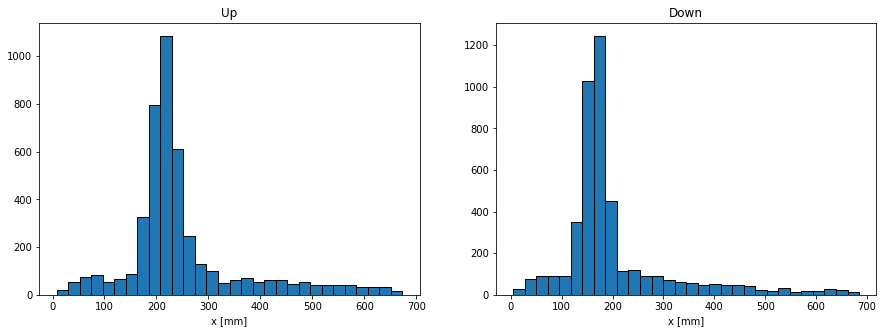

#### Difference in slope and intercept between chambers (local fits)

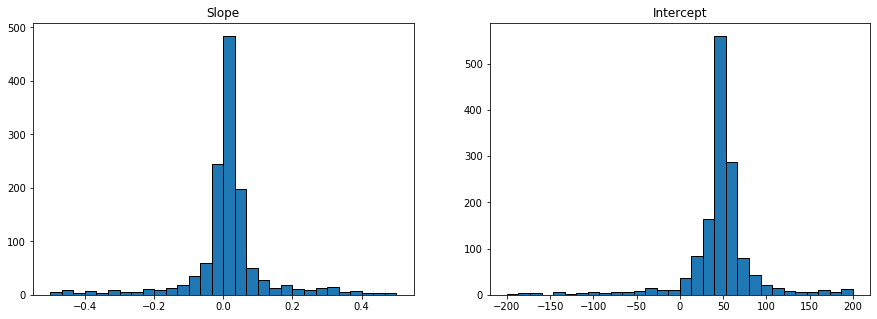

#### Residuals in the excluded layer

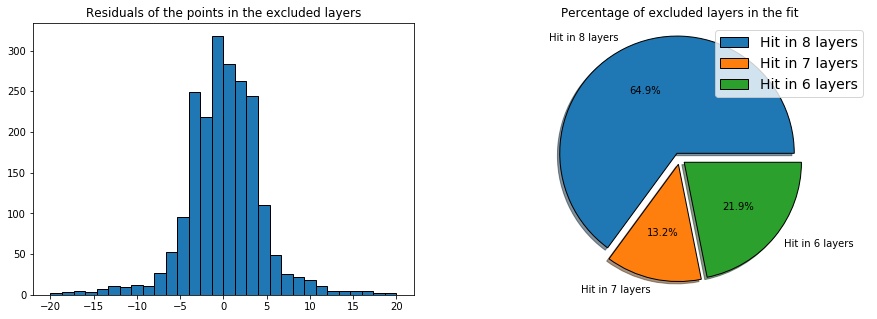

In [8]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)

### Run 262

#### Reading data

In [9]:
Ev_list = Open_File_Calibration(calibration_files[2])


Total number of events in the Run   = 5367
Number of accepted events           = 1609
Fraction of accepted events         = 29.9795 %


Performing fit and analysis


#### Hit position (cell local coordinates)

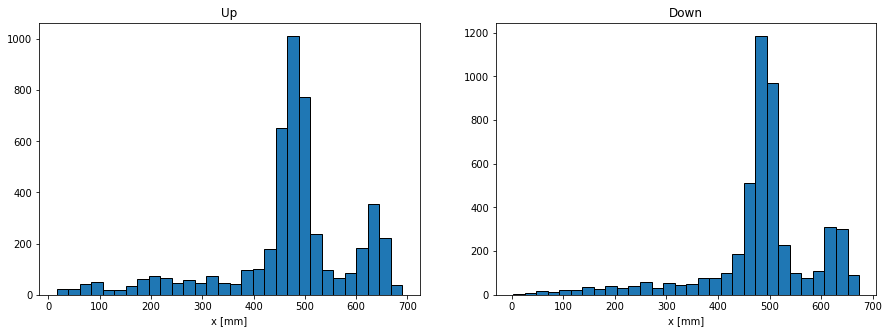

#### Difference in slope and intercept between chambers (local fits)

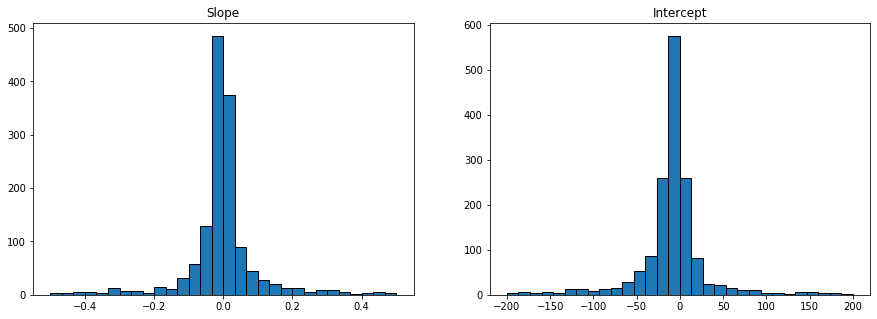

#### Residuals in the excluded layer

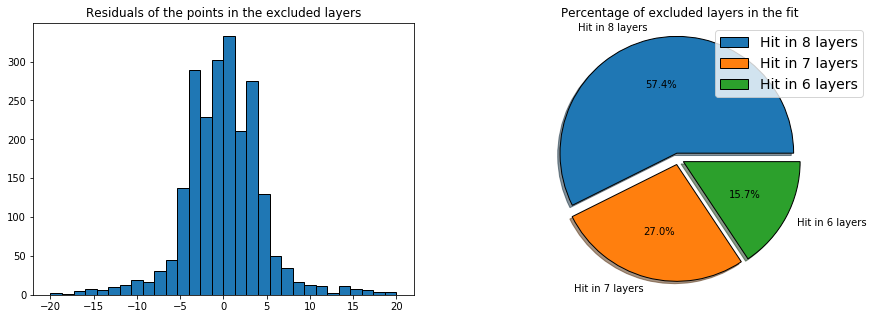

In [10]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)

### Run 263

#### Reading data

In [11]:
Ev_list = Open_File_Calibration(calibration_files[3])


Total number of events in the Run   = 1502
Number of accepted events           = 339
Fraction of accepted events         = 22.5699 %


Performing fit and analysis


#### Hit position (cell local coordinates)

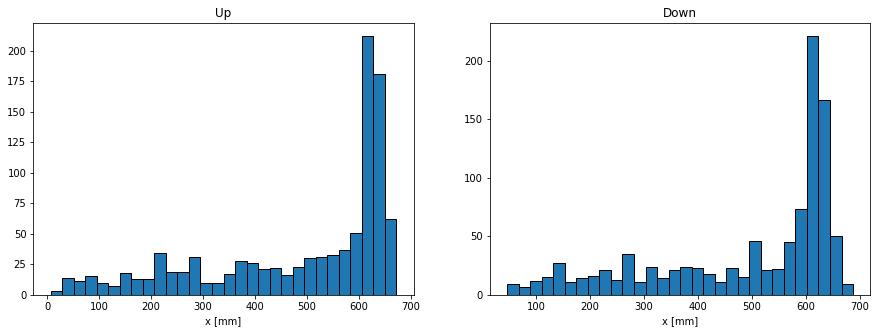

#### Difference in slope and intercept between chambers (local fits)

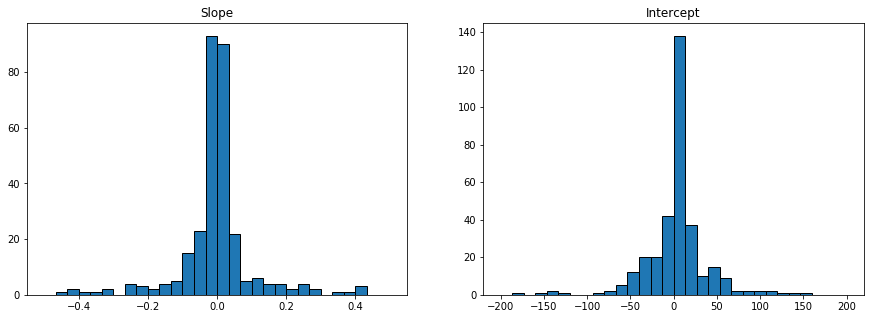

#### Residuals in the excluded layer

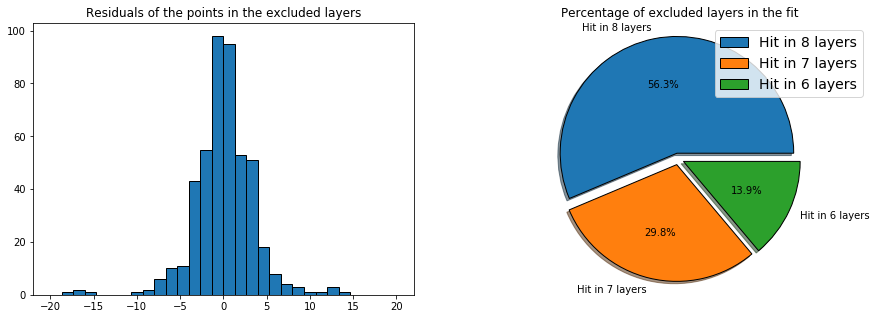

In [12]:
Ev_residuals, X_position, lf_diff = Calibration(Ev_list)